# Regression Trees & Random Forest Regression (apartment data)

In this notebook, we will use Regression Tree and Random Forest Regressors to predict rental apartment prices based on various features like living area, number of rooms and more. We will evaluate the models using goodness-of-fit measures like R-squared.

## Libraries and settings

In [23]:
# Libraries
import os
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

/workspaces/python_machine_learning_basics/CART_RandomForest


## Import the apartment data

In [2]:
# Define columns for import
columns = [ 'web-scraper-order',
            'address_raw',
            'rooms',
            'area',
            'luxurious',
            'price',
            'price_per_m2',
            'lat',
            'lon',
            'bfs_number',
            'bfs_name',
            'pop',
            'pop_dens',
            'frg_pct',
            'emp',
            'mean_taxable_income',
            'dist_supermarket']

# Read and select variables
df_orig = pd.read_csv("./Data/apartments_data_enriched_cleaned.csv", sep=";", encoding='utf-8')[columns]

# Rename variable 'web-scraper-order' to 'apmt_id'
df_orig = df_orig.rename(columns={'web-scraper-order': 'id'})

# Remove missing values
df = df_orig.dropna()
df.head(5)

# Remove duplicates
df = df.drop_duplicates()

# Remove some 'extreme' values
df = df.loc[(df['price'] >= 1000) & 
            (df['price'] <= 5000)]

# Reset index
df = df.reset_index(drop=True)

print(df.shape)
df.head(5)

(722, 17)


,id,address_raw,rooms,area,luxurious,price,price_per_m2,lat,lon,bfs_number,bfs_name,pop,pop_dens,frg_pct,emp,mean_taxable_income,dist_supermarket
0,1693998201-1,"Neuhusstrasse 6, 8630 Rüti ZH, ZH",3.0,49,0,1441,29.41,47.252171,8.845797,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,645.652248
1,1693998233-172,"Widacherstrasse 5, 8630 Rüti ZH, ZH",3.0,111,0,2600,23.42,47.252087,8.854919,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,265.102153
2,1693998256-331,"Widenweg 14, 8630 Rüti ZH, ZH",3.0,58,0,1490,25.69,47.253670,8.853993,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,94.401821
3,1693998265-381,"Rain 1, 8630 Rüti ZH, ZH",4.0,118,0,3240,27.46,47.259834,8.851705,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,106.660970
4,1693998276-419,"Bachtelstrasse 24b, 8630 Rüti ZH, ZH",3.0,66,0,1450,21.97,47.266113,8.866872,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,974.844209


In [24]:
# Define columns for import
columns = [ 'Offer_Id',
            'Type',
            'Fuel_Type',
            'Transmission',
            'Dealer_PLZ',
            'Dealer_City',
            'Dealer_Street_House_Nr',
            'Init_Regist_MY',
            'Init_Regist_Month',
            'Init_Regist_Year',
            'Init_Regist_Dt',
            'Make',
            'Mileage',
            'HP',
            'Price']

# Read and select variables
df_orig_car = pd.read_csv("/workspaces/python_machine_learning_basics/CART_RandomForest/Data/autoscout24_data_enriched_cleaned.csv", sep=",", encoding='utf-8')[columns]

# Rename variable 'web-scraper-order' to 'apmt_id'
df_orig_car = df_orig_car.rename(columns={'web-scraper-order': 'id'})


#convert a string value to an int
le = LabelEncoder()
df_orig_car['Transmission_int'] = le.fit_transform(df_orig_car['Transmission'])
df_orig_car['Fuel_Type_int'] = le.fit_transform(df_orig_car['Fuel_Type'])


# Remove missing values
df_car = df_orig_car.dropna()
df_car.head(5)

# Remove duplicates
df_car = df_car.drop_duplicates()

# Remove some 'extreme' values
df_car = df_car.loc[(df_car['Price'] >= 200) & 
            (df_car['Price'] <= 150000)]

# Reset index
df_car = df_car.reset_index(drop=True)

print(df_car.shape)
df_car.head(5)

(3950, 17)


,Offer_Id,Type,Fuel_Type,Transmission,Dealer_PLZ,Dealer_City,Dealer_Street_House_Nr,Init_Regist_MY,Init_Regist_Month,Init_Regist_Year,Init_Regist_Dt,Make,Mileage,HP,Price,Transmission_int,Fuel_Type_int
0,7324420,AUDI A5 Sportback 3.0 TDI quattro S-tronic (Li...,Diesel,Automatisiertes Schaltgetriebe,8488,Turbenthal,Mettlenstrasse 3,10.2014,10.0,2014.0,2014-10,AUDI,75000,245,22500,6,3
1,7512768,MERCEDES-BENZ SLK 200 7G-Tronic (Cabriolet),Benzin,Automat sequentiell,3186,Düdingen,Brugerastrasse 60,6.2013,6.0,2013.0,2013-06,MERCEDES-BENZ,46655,184,23749,2,2
2,7512034,MERCEDES-BENZ C 350 Avantgarde 4Matic 7G-Troni...,Benzin,Automat sequentiell,1262,Eysins,1262 Eysins,6.2011,6.0,2011.0,2011-06,MERCEDES-BENZ,138955,306,18500,2,2
3,7512728,MERCEDES-BENZ A 45 AMG 4Matic Speedshift 7G-DC...,Benzin,Automatisiertes Schaltgetriebe,4314,Zeiningen,Am Stutz 21,8.2015,8.0,2015.0,2015-08,MERCEDES-BENZ,43000,360,36000,6,2
4,7490242,AUDI A5 Sportback 2.0 TFSI Sport quattro S-tro...,Benzin,Automatisiertes Schaltgetriebe,3250,Lyss,3250 Lyss,9.2018,9.0,2018.0,2018-09,AUDI,43300,252,48500,6,2


## Regression Tree
See also: https://data36.com/regression-tree-python-scikit-learn

### Create train and test samples for the regression tree (train = 80%, test = 20% of the data)

In [13]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df[['area', 
                                                        'rooms',
                                                        'pop_dens',
                                                        'mean_taxable_income',
                                                        'dist_supermarket']], 
                                                        df['price'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
     area  rooms     pop_dens  mean_taxable_income  dist_supermarket
456   120    6.5   165.018625          65380.98802       1958.318650
6      65    3.5   525.662252         111422.35870        282.095910
362    90    3.5   424.146342          72133.75058       2606.231069
594    63    2.5  1044.628957          70964.08794        564.607066
439    91    3.5   399.525129          62000.54187        646.823905 

y_train:
456    1900
6      1850
362    2090
594    2102
439    1800
Name: price, dtype: int64


In [29]:
# Create train and test samples
X_train_car, X_test_car, y_train_car, y_test_car = train_test_split(df_car[['Mileage', 
                                                        'HP',
                                                        'Init_Regist_Year',
                                                        'Fuel_Type_int',
                                                        'Transmission_int']], 
                                                        df_car['Price'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X_train
print('X_train_car:')
print(X_train_car.head(), '\n')

# Show y_train
print('y_train:')
print(y_train_car.head())

X_train_car:
      Mileage   HP  Init_Regist_Year  Fuel_Type_int  Transmission_int
3769   114731  150            2009.0              3                 9
1407    77000  265            2013.0              2                 9
2775   134000  184            2011.0              3                 9
3341   132000  136            2012.0             15                 3
1116    79000  175            2013.0              3                 9 

y_train:
3769     6400
1407    19956
2775    12300
3341     8500
1116    14800
Name: Price, dtype: int64


### Fit the regression tree model

In [14]:
# Create decision tree regressor object
reg = DecisionTreeRegressor(random_state=20, max_depth=3)

# Train decision tree regressor
reg = reg.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = reg.predict(X_test)

In [30]:
# Create decision tree regressor object
reg_car = DecisionTreeRegressor(random_state=20, max_depth=3)

# Train decision tree regressor
reg_car = reg_car.fit(X_train_car, y_train_car)

# Predict the response for test dataset
y_pred_car = reg_car.predict(X_test_car)

### Calculate coefficient of determination (R-squared)

In [52]:
# Calculate coefficient of determination
print('R-squared:', round(r2_score(y_test, y_pred), 4))

R-squared: 0.4502


In [31]:
# Calculate coefficient of determination
print('R-squared:', round(r2_score(y_test_car, y_pred_car), 4))

R-squared: 0.5805


### Print text representation of the regression tree

In [53]:
# Text representation of the regression tree
text_representation = tree.export_text(reg, 
                                       feature_names=list(X_train.columns))

# Print text_representation
print(text_representation)

|--- area <= 99.50
|   |--- pop_dens <= 4269.10
|   |   |--- area <= 77.50
|   |   |   |--- value: [1722.86]
|   |   |--- area >  77.50
|   |   |   |--- value: [2191.39]
|   |--- pop_dens >  4269.10
|   |   |--- area <= 52.50
|   |   |   |--- value: [1893.80]
|   |   |--- area >  52.50
|   |   |   |--- value: [2927.78]
|--- area >  99.50
|   |--- area <= 134.00
|   |   |--- pop_dens <= 3874.83
|   |   |   |--- value: [2672.06]
|   |   |--- pop_dens >  3874.83
|   |   |   |--- value: [3603.59]
|   |--- area >  134.00
|   |   |--- pop_dens <= 1663.59
|   |   |   |--- value: [3391.42]
|   |   |--- pop_dens >  1663.59
|   |   |   |--- value: [4154.83]



In [28]:
# Text representation of the regression tree
text_representation_car = tree.export_text(reg_car, 
                                       feature_names=list(X_train_car.columns))

# Print text_representation
print(text_representation_car)

|--- HP <= 344.50
|   |--- Init_Regist_Year <= 2014.50
|   |   |--- Init_Regist_Year <= 1985.50
|   |   |   |--- value: [38077.62]
|   |   |--- Init_Regist_Year >  1985.50
|   |   |   |--- value: [14411.13]
|   |--- Init_Regist_Year >  2014.50
|   |   |--- HP <= 233.00
|   |   |   |--- value: [25145.15]
|   |   |--- HP >  233.00
|   |   |   |--- value: [43422.20]
|--- HP >  344.50
|   |--- Mileage <= 86500.00
|   |   |--- HP <= 478.50
|   |   |   |--- value: [59803.06]
|   |   |--- HP >  478.50
|   |   |   |--- value: [82965.41]
|   |--- Mileage >  86500.00
|   |   |--- Mileage <= 125294.50
|   |   |   |--- value: [39427.69]
|   |   |--- Mileage >  125294.50
|   |   |   |--- value: [26367.88]



### Vizualizing the regression tree

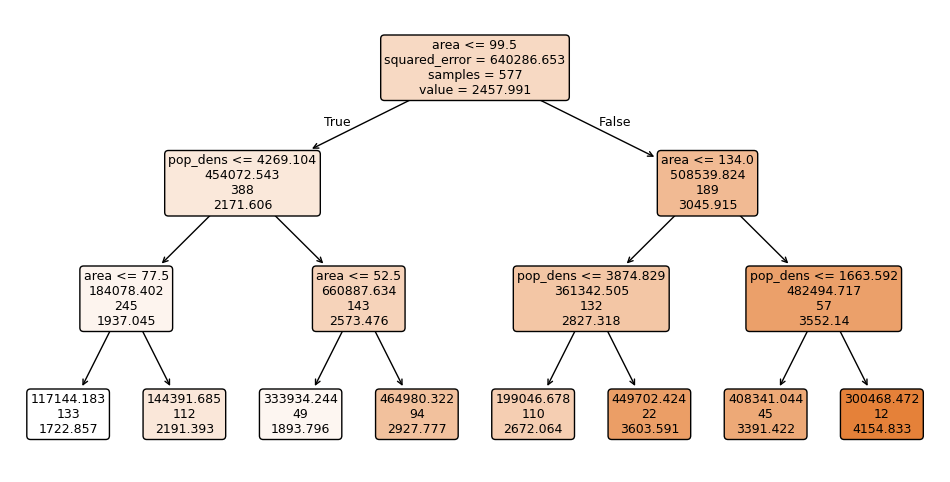

In [54]:
fig = plt.figure(figsize=(12,6))
_ = tree.plot_tree(reg, 
                   feature_names=list(X_train.columns),  
                   class_names=['price'],
                   filled=True,
                   fontsize=9,
                   label='root',
                   rounded=True)

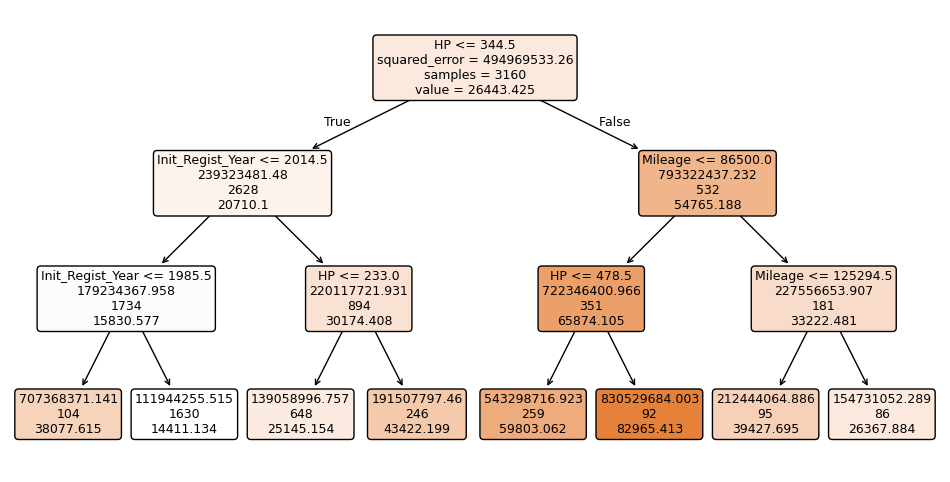

In [32]:
fig_car = plt.figure(figsize=(12,6))
_ = tree.plot_tree(reg_car, 
                   feature_names=list(X_train_car.columns),  
                   class_names=['price'],
                   filled=True,
                   fontsize=9,
                   label='root',
                   rounded=True)

## Random Forest Regression
For details see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

### Create train and test samples for the random forest (train = 80%, test = 20% of the data)

In [21]:
# Create train and test samples (the names X2_ and y2_ were used because X_ and y_ were already used above)
X2_train, X2_test, y2_train, y2_test = train_test_split(df[['area', 
                                                            'rooms',
                                                            'pop_dens',
                                                            'mean_taxable_income',
                                                            'dist_supermarket']], 
                                                            df['price'], 
                                                            test_size=0.20, 
                                                            random_state=42)

# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())

X2_train:
     area  rooms     pop_dens  mean_taxable_income  dist_supermarket
456   120    6.5   165.018625          65380.98802       1958.318650
6      65    3.5   525.662252         111422.35870        282.095910
362    90    3.5   424.146342          72133.75058       2606.231069
594    63    2.5  1044.628957          70964.08794        564.607066
439    91    3.5   399.525129          62000.54187        646.823905 

y2_train:
456    1900
6      1850
362    2090
594    2102
439    1800
Name: price, dtype: int64


In [34]:
# Create train and test samples (the names X2_ and y2_ were used because X_ and y_ were already used above)
X2_train_car, X2_test_car, y2_train_car, y2_test_car = train_test_split(df_car[['Mileage', 
                                                        'HP',
                                                        'Init_Regist_Year',
                                                        'Transmission_int']], 
                                                            df_car['Price'], 
                                                            test_size=0.20, 
                                                            random_state=42)

# Show X2_train
print('X2_train_car:')
print(X2_train_car.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train_car.head())

X2_train_car:
      Mileage   HP  Init_Regist_Year  Transmission_int
3769   114731  150            2009.0                 9
1407    77000  265            2013.0                 9
2775   134000  184            2011.0                 9
3341   132000  136            2012.0                 3
1116    79000  175            2013.0                 9 

y2_train:
3769     6400
1407    19956
2775    12300
3341     8500
1116    14800
Name: Price, dtype: int64


### Fit the Random Forest Regression

In [35]:
X, y = make_regression(n_features=4, n_informative=2,
                       random_state=5, shuffle=False)


reg_rf = RandomForestRegressor(n_estimators=500, 
                               max_depth=10, 
                               random_state=5)
reg_rf.fit(X2_train, y2_train)

# Calculate coefficient of determination (R-squared)
print('R-squared:', round(reg_rf.score(X2_test, y2_test), 4))

R-squared: 0.5481


In [36]:
X_car, y_car = make_regression(n_features=4, n_informative=2,
                       random_state=5, shuffle=False)


reg_rf_car = RandomForestRegressor(n_estimators=500, 
                               max_depth=10, 
                               random_state=5)
reg_rf_car.fit(X2_train_car, y2_train_car)

# Calculate coefficient of determination (R-squared)
print('R-squared:', round(reg_rf_car.score(X2_test_car, y2_test_car), 4))

R-squared: 0.7592


### Show feature importance

Index(['area', 'pop_dens', 'dist_supermarket', 'mean_taxable_income', 'rooms'], dtype='object')
[0.56749536 0.16751781 0.11611526 0.09147853 0.05739305]


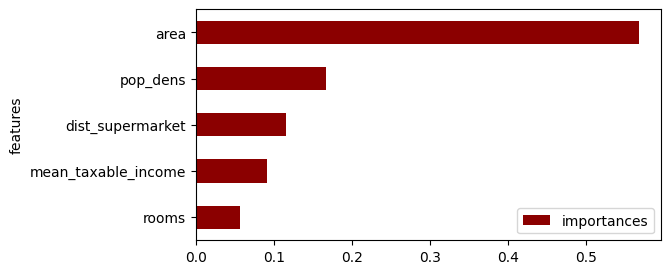

In [37]:
cols = X2_train.columns

# Derive feature importance from random forest
importances = reg_rf.feature_importances_
std         = np.std([tree.feature_importances_ for tree in reg_rf.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,3))

plt.show()

Index(['HP', 'Mileage', 'Init_Regist_Year', 'Transmission_int'], dtype='object')
[0.54668287 0.22380164 0.19712789 0.0323876 ]


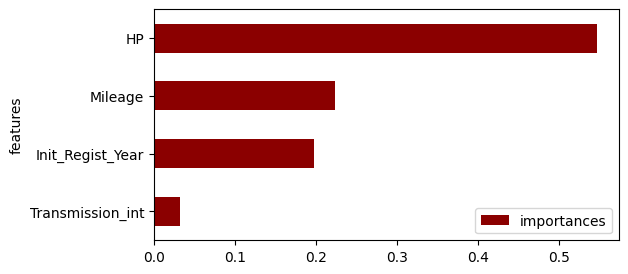

In [38]:
cols_car = X2_train_car.columns

# Derive feature importance from random forest
importances_car = reg_rf_car.feature_importances_
std_car         = np.std([tree.feature_importances_ for tree in reg_rf_car.estimators_], axis=0)
indices_car     = np.argsort(importances_car)[::-1]

# Print col-names and importances-values
print( cols_car[indices_car] )
print( importances_car[indices_car] )

# Barplot with feature importance
df_fi_car = pd.DataFrame({'features':cols_car,'importances': importances_car})
df_fi_car.sort_values('importances', inplace=True)
df_fi_car.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,3))

plt.show()

### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [58]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.5.0-1025-azure
Datetime: 2024-10-29 13:35:41
Python Version: 3.11.10
-----------------------------------
